In [1]:
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D, Conv2DTranspose, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import concatenate, LeakyReLU, BatchNormalization, Dense, Activation, Reshape
from keras.optimizers import *
from keras.datasets import mnist

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from typing import List # Type hints requires Python >= 3.5

# Local imports
from unet import unet_cell, LEAKY_RELU_ALPHA, BATCH_NORM_MOMENTUM

Using TensorFlow backend.


In [2]:
# Load MNIST training data
(X_train, _), (_, _) = mnist.load_data() # No need for labels or test set
X_train = X_train.reshape(-1, 28, 28, 1)
X_train = X_train / 255.0 # Normalize

In [3]:
# Create a function for constructing the upscaler (aka generator)
def build_upscaler(inputs, # TODO: What type is this?
                   num_filters_in_layer: List[int]=[16, 32, 64],
                   num_cells_in_layer: List[int]=[3, 3, 3],
                   bottleneck_before_concat: bool=False) -> Model:
    """Build a model which upscales inputs by factor of 4 (i.e., 
       doubles the height and width of inputs)
    
    # Arguments
        inputs (Tensor): images to be upscaled; must have 
            data_format == 'channels_last' # TODO: Enable both formats
            
        num_filters_in_layer (list of ints): how many filters are 
            used in each layer. (Note: a "layer" consists of
            successive applications of stride=1 convolution; two 
            layers are separated by a pooling or upsampling operation. 
            The length of this list tells us how many layers we have.)
            
        num_cells_in_layer (list of ints): how many successive 
            applications of convolution + BN + activation are applied 
            before starting a new layer.
            
        bottleneck_before_concat (bool): whether or not to apply a 
            convolution with 1x1 kernels prior to concatenating 
            (doing so will reduce the total number of parameters 
            required by the upscaler)
    
    # Returns
        Keras Model which takes in an image tensor and returns 
        a tensor of upscaled images.
    """
    
    # Validate inputs
    if len(num_filters_in_layer) != len(num_cells_in_layer):
        raise ValueError("len(num_filters_in_layer) should equal "
            "len(num_cells_in_layer). Received lengths: "
            "({}, {})".format(len(num_filters_in_layer), len(num_cells_in_layer)))
    
    x = inputs
    x = UpSampling2D()(x)
    carry_forward_tensors = []

    # Zip the parameters that apply to the encoder (exclude last 
    # parameters for bottom layer)
    contraction_filters_and_cells = zip(num_filters_in_layer[:-1],
                                        num_cells_in_layer[:-1])

    # Encoder
    for i, (num_filters, num_cells) in enumerate(contraction_filters_and_cells):
        if i == 0:
            # First layer does not downsample
            for j in range(num_cells):
                x = unet_cell(x, num_filters=num_filters) 
                # Note: We make extensive use of default values.
        else:
            # Downsample first
            x = unet_cell(x, num_filters=num_filters, strides=2)
            for j in range(num_cells - 1):
                x = unet_cell(x, num_filters=num_filters)
        carry_forward_tensors.append(x)

    # Bottom layer
    num_filters_at_bottom = num_filters_in_layer[-1]
    num_cells_at_bottom = num_cells_in_layer[-1]

    x = unet_cell(x, num_filters=num_filters_at_bottom, strides=2)
    for i in range(num_cells_at_bottom - 1):
        x = unet_cell(x, num_filters=num_filters_at_bottom)

    # Decoder
    filters_cells_and_carrys = reversed(
        list(zip(num_filters_in_layer[:-1],
                 num_cells_in_layer[:-1],
                 carry_forward_tensors)))
    
    for num_filters, num_cells, carry in filters_cells_and_carrys:
        # First, we upsample the output of the previous layer
        # TODO: parametrize upsampling method (Conv2DTrans vs UpSample2D)
        x = unet_cell(x, transpose_conv=True, num_filters=num_filters, strides=2)
        if bottleneck_before_concat:
            x = unet_cell(x, num_filters=num_filters//2, kernel_size=1)
            carry = unet_cell(carry, num_filters=num_filters//2, kernel_size=1)
        x = concatenate([x, carry])
        # Then, we apply successive convolution
        for _ in range(num_cells - 1):
            x = unet_cell(x, num_filters=num_filters)

    # Output
    x = unet_cell(x, num_filters=1, kernel_size=1, activation='sigmoid',
                  batch_normalization=False)

    model = Model(inputs=inputs, outputs=x)
    return model

In [4]:
# TODO: Test keras.applications (ResNet, Xception, etc.) as discriminators
# Note: ResNet, Xception have *required* input dimensions larger than 
# something on the order of 100x100...
# Instead, consider implementing and using ResNet / Xception cells
def build_discriminator(low_res_input, high_res_input, # TODO: What type are these?
                        num_filters_in_layer: List[int]=[16, 32, 64],
                        num_cells_in_layer: List[int]=[3, 3, 3],
                        num_units_in_dense_layer: List[int]=[]):
    """Builds a model which classifies high_res_input as real
       or generated (where "real" -> 1, "generated" -> 0).
    
    # Arguments
        low_res_input (Tensor): low resolution images
        
        high_res_input (Tensor): upsampled versions of low_res_input
        
        # Note: both input tensors should have data_format == 'channels_last'
        # TODO: Enable both formats
        
        num_filters_in_layer (list of ints): how many filters are 
            used in each layer. (Note: a "layer" consists of
            successive applications of stride=1 convolution; two 
            layers are separated by a pooling operation. The length 
            of this list tells us how many layers we have.)
            
        num_cells_in_layer (list of ints): how many successive 
            applications of convolution + BN + activation are applied 
            before starting a new layer.
            
        num_units_in_dense_layer (list of ints): how many units are 
            used in each dense layer (Note: the length of this list 
            tells us how many dense layers we have before the final 
            classification layer.)
    
    # Returns
        Keras Model which takes in two image tensors (low_res_input, 
        high_res_input) and returns a scalar between [0, 1] which 
        represents how realistic high_res_input appears.
    """
    
    # Validate inputs
    if len(num_filters_in_layer) != len(num_cells_in_layer):
        raise ValueError("len(num_filters_in_layer) should equal "
            "len(num_cells_in_layer). Received lengths: "
            "({}, {})".format(len(num_filters_in_layer), len(num_cells_in_layer)))
    
    x = low_res_input
    x = UpSampling2D()(x)
    x = concatenate([x, high_res_input])
    
    filters_and_cells = zip(num_filters_in_layer, num_cells_in_layer)
    
    for i, (num_filters, num_cells) in enumerate(filters_and_cells):
        for j in range(num_cells):
            x = unet_cell(x, num_filters=num_filters) # TODO: Rename `unet_cell`
        x = MaxPooling2D(pool_size=2)(x)
    
    x = GlobalAveragePooling2D()(x)
    x = LeakyReLU(alpha=LEAKY_RELU_ALPHA)(x)
    x = BatchNormalization(momentum=BATCH_NORM_MOMENTUM)(x)
    
    for num_units in num_units_in_dense_layer:
        x = Dense(units=num_units)(x)
        x = LeakyReLU(alpha=LEAKY_RELU_ALPHA)(x)
        x = BatchNormalization(momentum=BATCH_NORM_MOMENTUM)(x)
    
    validity = Dense(units=1, activation='sigmoid')(x)

    model = Model(inputs=[low_res_input, high_res_input], outputs=validity)
    return model

In [5]:
# Define inputs
low_res_input = Input(shape=(None, None, 1))
# TODO: dimensions of low_res_input should probably be divisible 
# by 2**{num_layers}
high_res_input = Input(shape=(None, None, 1)) # This should really have dimensions twice that of low_res_input

# Build upscaler / discriminator
upscaler = build_upscaler(low_res_input) # Use default parameters
discriminator = build_discriminator(low_res_input, high_res_input) # Use default parameters

# Define optimizers and compile models
upscaler_optimizer = Adam(0.001, 0.5)
upscaler.compile(loss='binary_crossentropy', 
                 optimizer=upscaler_optimizer)

discriminator_optimizer = Adam(0.0002, 0.5)
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=discriminator_optimizer, 
                      metrics=['accuracy'])

discriminator.trainable = False

upscaled_imgs = upscaler(low_res_input)
valid = discriminator([low_res_input, upscaled_imgs])

# The combined model  (stacked upscaler and discriminator) takes
# low-res image as input and returns an upsampled image from the 
# upscaler and a validity score given by the discriminator
combined = Model(low_res_input, [valid, upscaled_imgs])
combined.compile(loss=['binary_crossentropy', 'mean_absolute_error'], 
                 optimizer=upscaler_optimizer, 
                 metrics = ['accuracy'])
# Notice: the combined model was compiled *after* freezing the discriminator's weights

combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, None, None, 1 179969      input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            122097      input_1[0][0]                    
                                                                 model_1[1][0]                    
Total params: 302,066
Trainable params: 179,009
Non-trainable params: 123,057
__________________________________________________________________________________________________


In [6]:
def reduce_resolution(ims):
    O, M, N, P = ims.shape
    K = 2
    L = 2

    MK = M // K
    NL = N // L
    return ims.reshape(-1, MK, K, NL, L).mean(axis=(2, 4)).reshape(O, MK, NL, P)

In [7]:
# Define training parameters
train_steps = 1000
print_every_n_steps = 1
print_results = False
plot_results = False
batch_size = 200
half_batch = batch_size // 2

# Create a dictionary for storing training metrics over time
training_metrics = {
    'step': [],
    'd_loss': [],
    'd_acc': [],
    'g_loss': []
}

In [8]:
for step in range(1, train_steps + 1):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    num_images = len(X_train)
    random_idxs = np.random.randint(num_images, size=half_batch)
    real_imgs = X_train[random_idxs]
    low_res_real_imgs = reduce_resolution(real_imgs)

    random_idxs = np.random.randint(num_images, size=half_batch)
    imgs_for_upscaler = X_train[random_idxs]
    low_res_imgs = reduce_resolution(imgs_for_upscaler)

    # Generate a half batch of upsampled images
    gen_imgs = upscaler.predict(low_res_imgs)
    
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(
        x=[low_res_real_imgs, real_imgs], # Training data
        y=np.ones(shape=(half_batch, 1))) # Labels
    
    d_loss_fake = discriminator.train_on_batch(
        x=[low_res_imgs, gen_imgs],        # Training data
        y=np.zeros(shape=(half_batch, 1))) # Labels
    
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train upscaler
    # ---------------------

    random_idxs = np.random.randint(num_images, size=batch_size)
    original_imgs = X_train[random_idxs]
    new_low_res_imgs = reduce_resolution(original_imgs)

    # The upscaler wants the discriminator to label the generated 
    # samples as valid (ones)
    valid_y = np.array([1] * batch_size)
    
    # Train the upscaler
    g_loss = combined.train_on_batch(
        x=new_low_res_imgs, 
        y=[valid_y, original_imgs])
        
    if step % print_every_n_steps == 0:
        # Store metrics over time
        training_metrics['step'].append(step)
        training_metrics['d_loss'].append(d_loss[0])
        training_metrics['d_acc'].append(d_loss[1])
        training_metrics['g_loss'].append(g_loss[0])
        
        # Print current metrics
        if print_results:
            print("Step {}:".format(step))
            print("    [D loss: {:0.6f}, accuracy: {:0.4f}]".format(
                training_metrics['d_loss'][-1],
                training_metrics['d_acc'][-1]))
            print("    [G loss: {:0.6f}]".format(
                training_metrics['g_loss'][-1]))
        
        # Plot example low_res vs upsampling vs original
        if plot_results:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
            ax1.imshow(low_res_imgs[0, :, :, 0])
            ax2.imshow(gen_imgs[0, :, :, 0])
            ax3.imshow(imgs_for_upscaler[0, :, :, 0])
            plt.show()

/opt/modules/devel/python/3.5.2/lib/python3.5/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


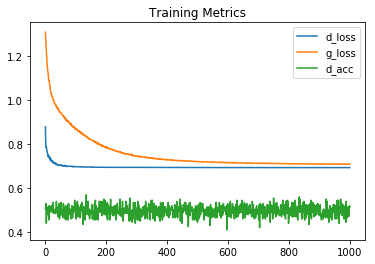

In [9]:
steps = training_metrics['step']
for key, values in training_metrics.items():
    if key == 'step': continue
    plt.plot(steps, values, label=key)
plt.title('Training Metrics')
plt.legend();

In [18]:
def save_models():
    upscaler.save('./models/upscaler_mnist.h5')
    discriminator.save('./models/discriminator_mnist.h5')
    combined.save('./models/combined_mnist.h5')

In [19]:
def show_examples():
    from keras.models import load_model

    # Load the upscaler
    upscaler = load_model('./models/upscaler_mnist.h5')

    # Upsample five images
    fi = 314 # First index
    images = X_train[fi:fi + 5]
    upsampled = upscaler.predict(images)
    upupsampled = upscaler.predict(upsampled)

    # Create a figure showing the results
    for i, (original, up, upup) in enumerate(zip(images, upsampled, upupsampled)):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        if i == 0:
            fig.suptitle("Original vs Upsampled vs Twice Upsampled")
        ax1.imshow(original[:, :, 0])
        ax2.imshow(up[:, :, 0])
        ax3.imshow(upup[:, :, 0])
        plt.show()

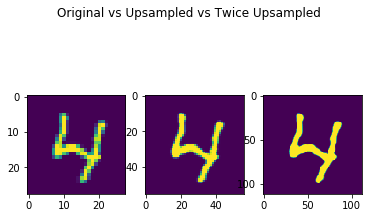

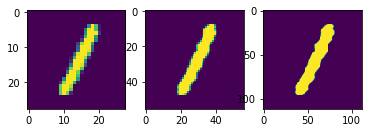

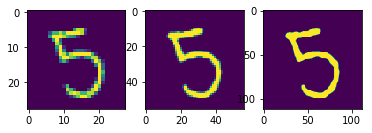

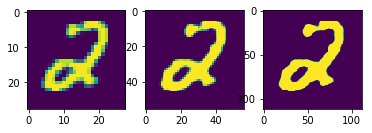

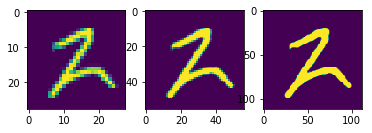

In [20]:
# save_models()
# show_examples()